In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df=df=df.sort_values(by="LogP",ascending=False)
df

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
815,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)c(C(F)(F)F...,9.00,552.936,8.1220,0.230244
121,O=C(Nc1ccc(C(=O)N=Nc2c(O)[nH]c3ccc(Br)cc23)cc1...,6.62,580.748,7.8763,0.183872
386,O=C(Nc1ccc(C(=O)N=Nc2c(O)[nH]c3ccc(Cl)cc23)cc1...,5.56,536.297,7.7672,0.199617
954,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5Cl)cccc...,8.70,519.384,7.7566,0.248402
1309,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5cc(Cl)cc(Cl)c5)cc...,9.52,519.384,7.7566,0.248402
...,...,...,...,...,...
615,COc1c[nH]c(=Nc2cnn(C)c2)[nH]c1=NC1C2C=CC(C2)C1...,6.04,355.402,-0.1060,0.662527
1177,Cn1cc(N=c2[nH]cc([N+](=O)[O-])c(=NC3C4C=CC(C4)...,7.30,370.373,-0.2064,0.385946
1370,CNC(=O)Cn1cc(N=c2[nH]cc(Cl)c(=NC3C4C=CC(C4)C3C...,8.22,416.873,-0.2522,0.498003
1288,NC(=O)Cn1cc(N=c2[nH]cc(Cl)c(=NC3C4C=CC(C4)C3C(...,7.75,402.846,-0.5129,0.496209


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=20488):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]

    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_RF_training batches.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_RF_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=0.544528789888252, pvalue=4.810945877209461e-14)
PearsonRResult(statistic=0.6026952986785824, pvalue=1.3609332628173324e-17)
PearsonRResult(statistic=0.7053809292083794, pvalue=5.408998081762508e-26)
PearsonRResult(statistic=0.7652619871911293, pvalue=8.310899031724583e-33)
PearsonRResult(statistic=0.724763418864232, pvalue=5.311842379949266e-28)
PearsonRResult(statistic=0.6909329882174167, pvalue=1.3388338781741867e-24)
PearsonRResult(statistic=0.7570043249308893, pvalue=9.452441345499466e-32)
PearsonRResult(statistic=0.617617944296639, pvalue=1.267209750785657e-18)
PearsonRResult(statistic=0.6605592200951756, pvalue=4.785528474270303e-22)


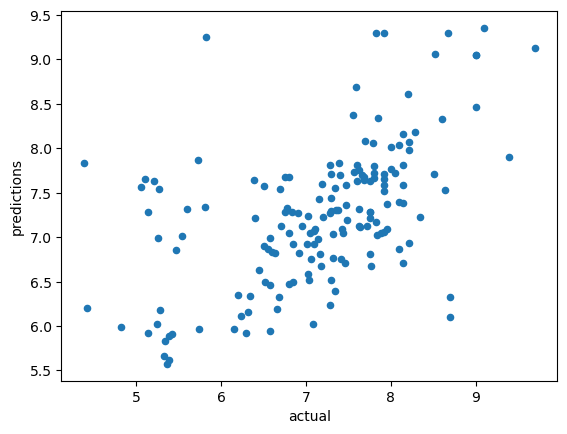

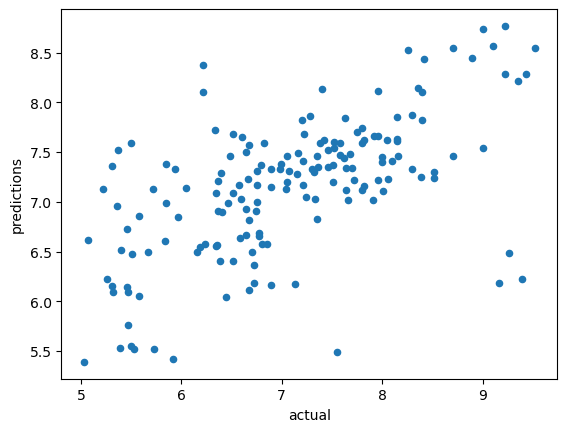

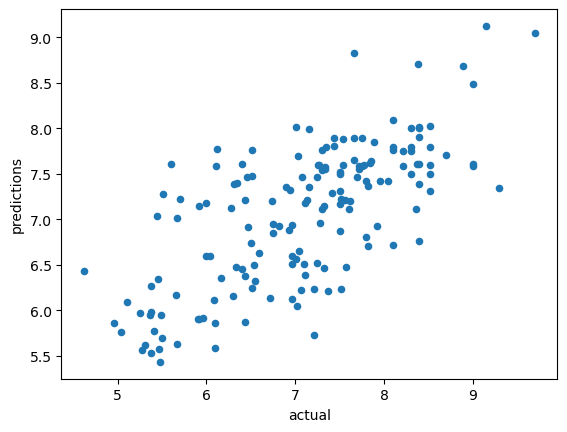

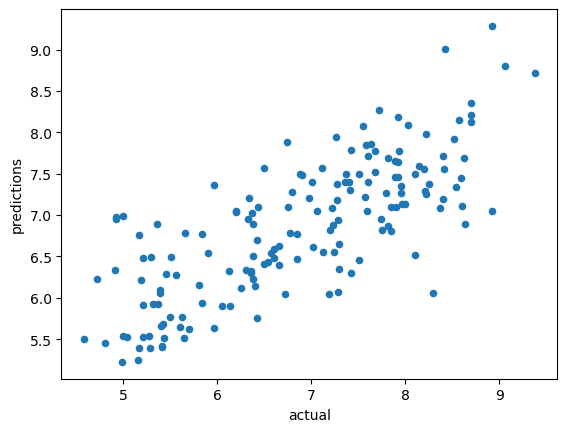

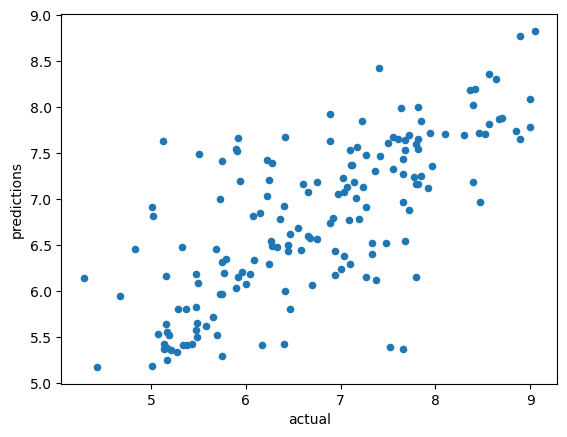

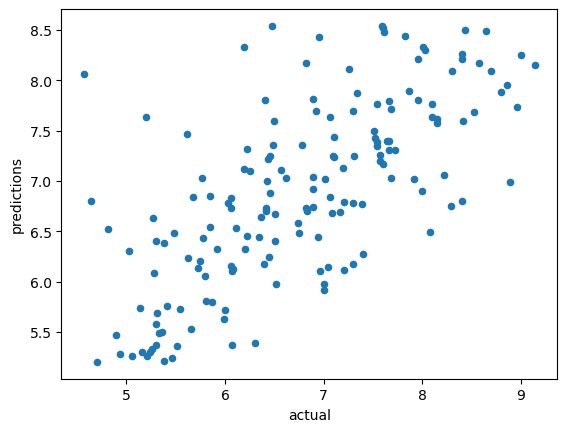

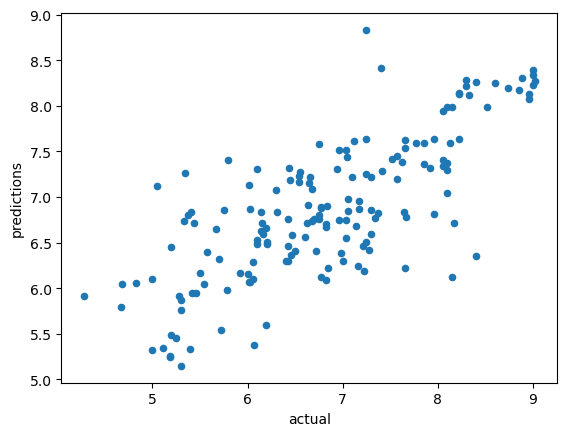

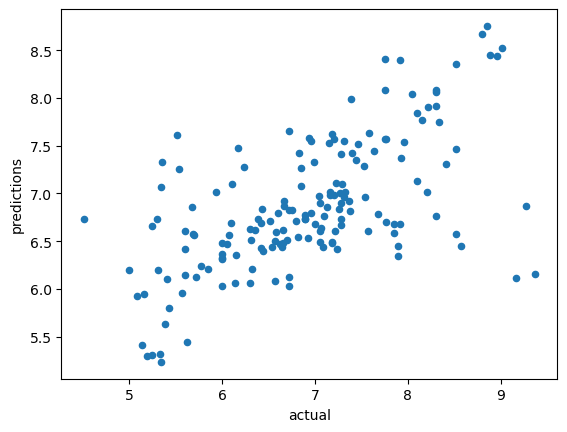

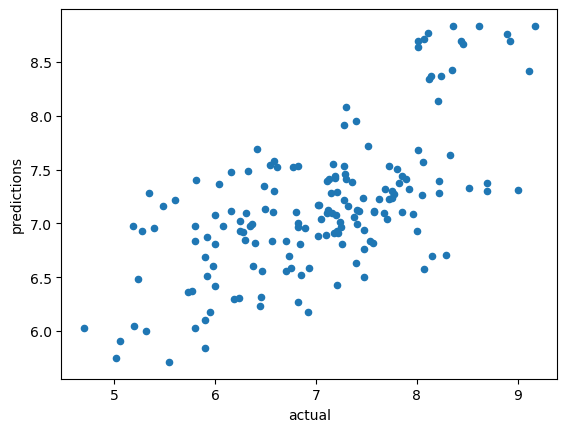

In [6]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [7]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(2, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [8]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(1, 3)
(0, 3)
(0, 3)


In [9]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(7, 3)
(2, 3)
(4, 3)
(14, 3)
(15, 3)
(10, 3)
(11, 3)
(6, 3)
(4, 3)


In [10]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(157, 3)
(162, 3)
(160, 3)
(150, 3)
(147, 3)
(153, 3)
(151, 3)
(158, 3)
(160, 3)


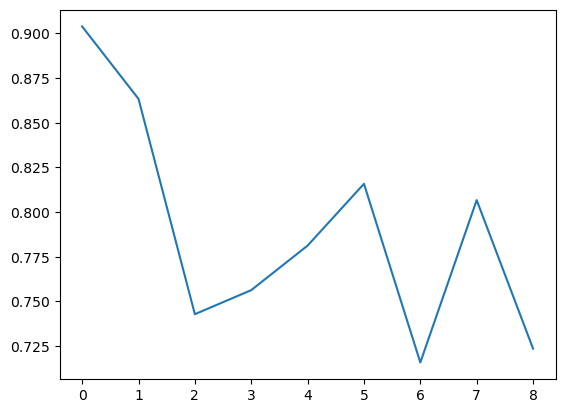

[0.9038297012039397, 0.8633247432000717, 0.742857862749083, 0.7563144893464575, 0.7812362052807484, 0.8158086239750304, 0.7158452117230957, 0.8066901928975417, 0.7235861544167609]


In [11]:
plt.plot(rmse)
plt.show()
print(rmse)

In [12]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

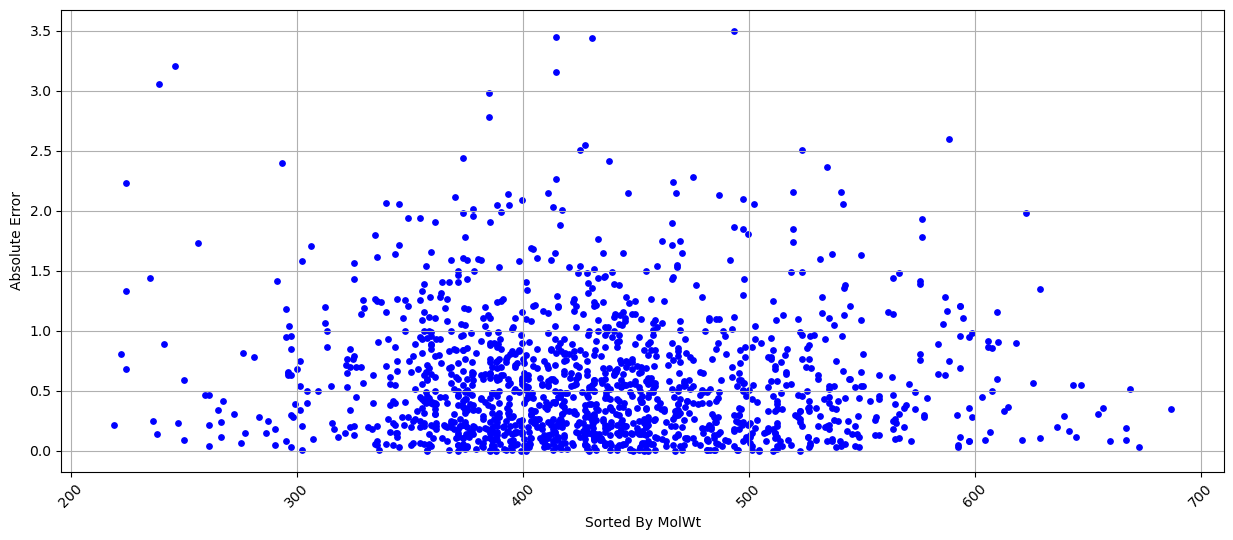

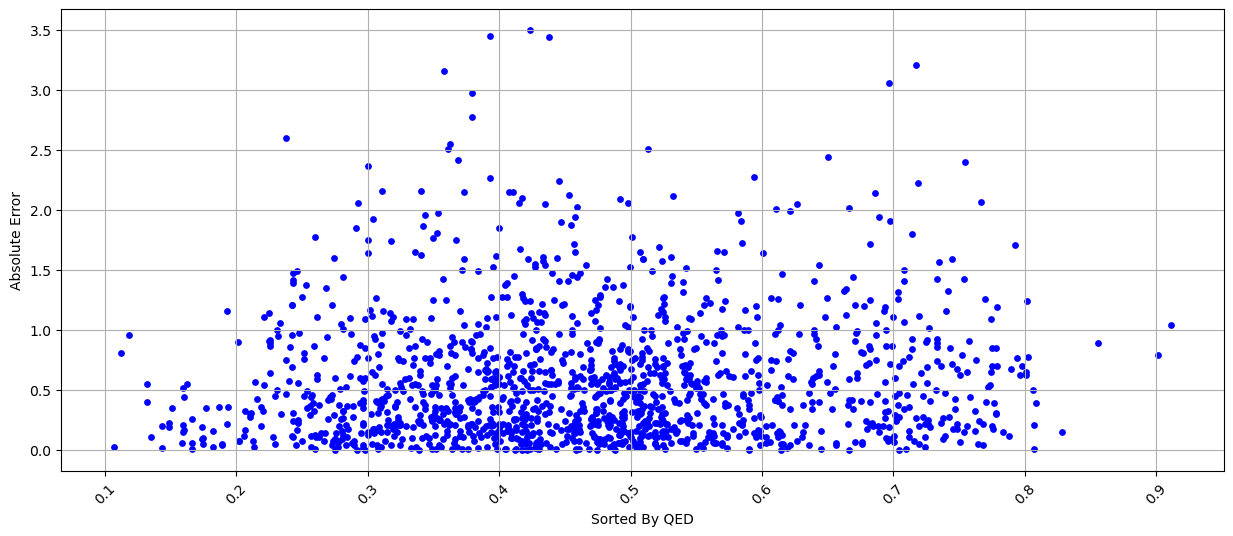

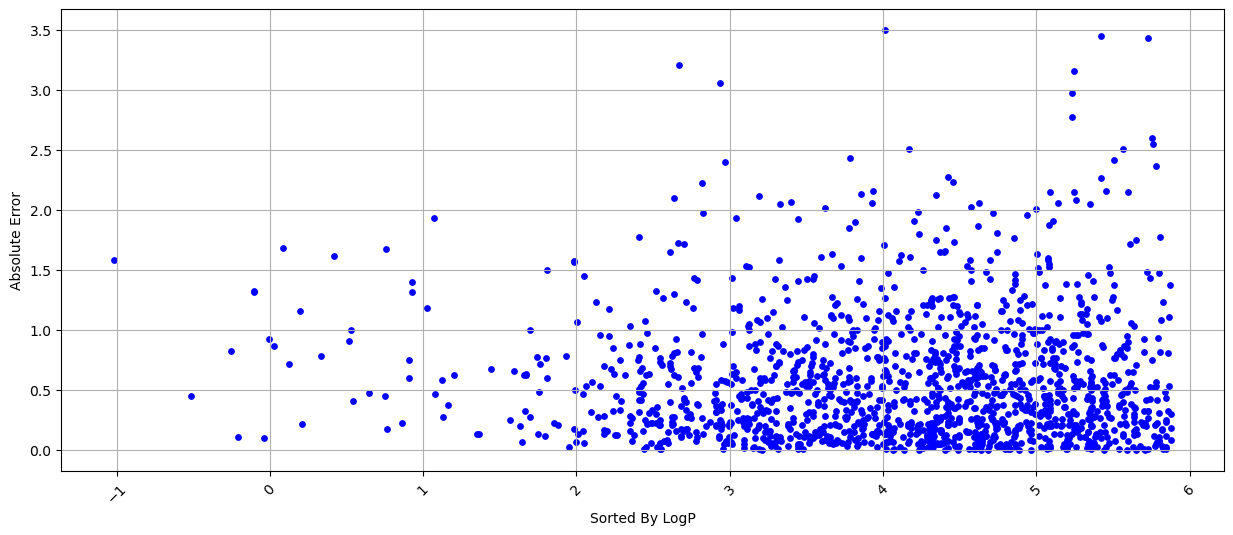

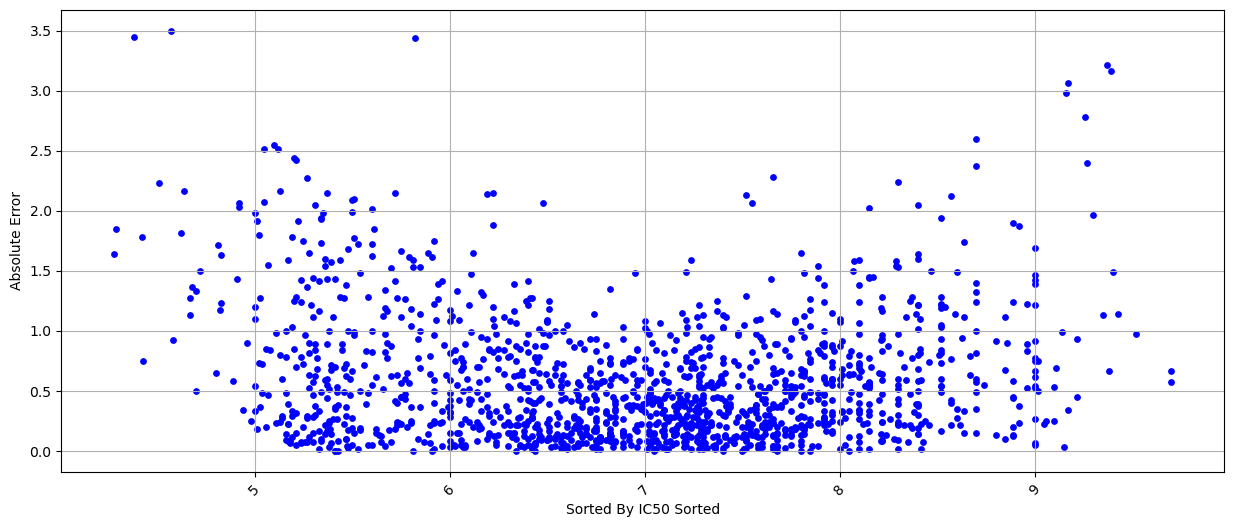

In [13]:
plot_graphs(df, results_df)

In [14]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
815,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)c(C(F)(F)F...,9.00,552.936,8.1220,0.230244,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
121,O=C(Nc1ccc(C(=O)N=Nc2c(O)[nH]c3ccc(Br)cc23)cc1...,6.62,580.748,7.8763,0.183872,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
386,O=C(Nc1ccc(C(=O)N=Nc2c(O)[nH]c3ccc(Cl)cc23)cc1...,5.56,536.297,7.7672,0.199617,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
954,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5ccc(Cl)cc5Cl)cccc...,8.70,519.384,7.7566,0.248402,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1309,COc1cc2nccc(Oc3ccc4c(C(=O)Nc5cc(Cl)cc(Cl)c5)cc...,9.52,519.384,7.7566,0.248402,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
615,COc1c[nH]c(=Nc2cnn(C)c2)[nH]c1=NC1C2C=CC(C2)C1...,6.04,355.402,-0.1060,0.662527,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1177,Cn1cc(N=c2[nH]cc([N+](=O)[O-])c(=NC3C4C=CC(C4)...,7.30,370.373,-0.2064,0.385946,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1370,CNC(=O)Cn1cc(N=c2[nH]cc(Cl)c(=NC3C4C=CC(C4)C3C...,8.22,416.873,-0.2522,0.498003,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1288,NC(=O)Cn1cc(N=c2[nH]cc(Cl)c(=NC3C4C=CC(C4)C3C(...,7.75,402.846,-0.5129,0.496209,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        
        X_test = X[(len(X)-fold_size):(len(X))]
        y_test = y[(len(X)-fold_size):(len(X))]
        smiles_test = smiles[(len(X)-fold_size):(len(X))] 
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = RandomForestRegressor(n_estimators=min(25,round(np.sqrt(X_train.shape[0]))), random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("logp_sorted_fcv_results_RF_training batches_druglike.csv", index=False)
    test_df.to_csv("logp_sorted_fcv_results_RF_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

PearsonRResult(statistic=-0.32746099104137383, pvalue=1.8682501134909142e-05)
PearsonRResult(statistic=-0.09840213463023798, pvalue=0.2099990116864871)
PearsonRResult(statistic=0.10858939970574996, pvalue=0.1663331739932874)
PearsonRResult(statistic=0.08378642107936249, pvalue=0.28612564773034665)
PearsonRResult(statistic=0.058121589592546895, pvalue=0.45975423745028743)
PearsonRResult(statistic=0.0962063626083056, pvalue=0.22040057304448465)
PearsonRResult(statistic=-0.011251221473437649, pvalue=0.8862993624858331)
PearsonRResult(statistic=0.21356151946466606, pvalue=0.006037208117489635)
PearsonRResult(statistic=0.6606716769351529, pvalue=6.257298251102387e-22)


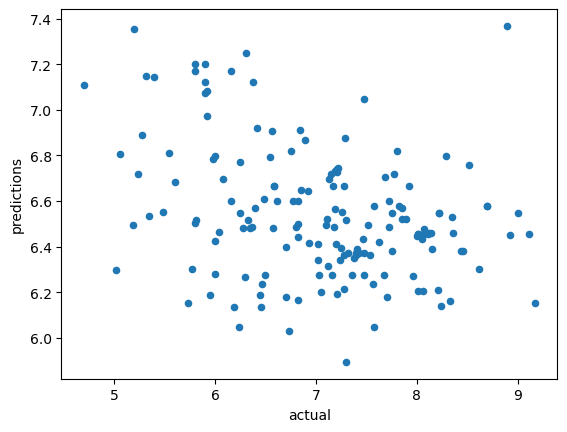

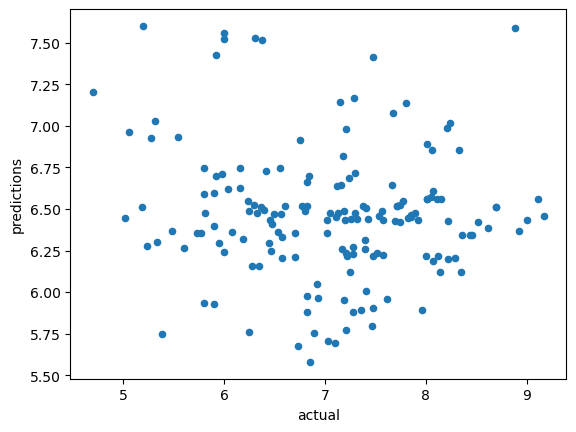

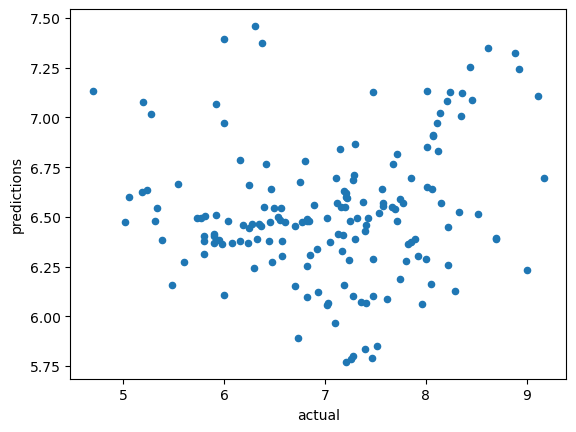

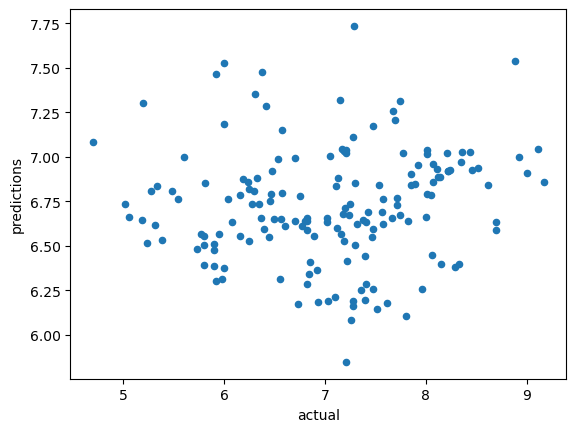

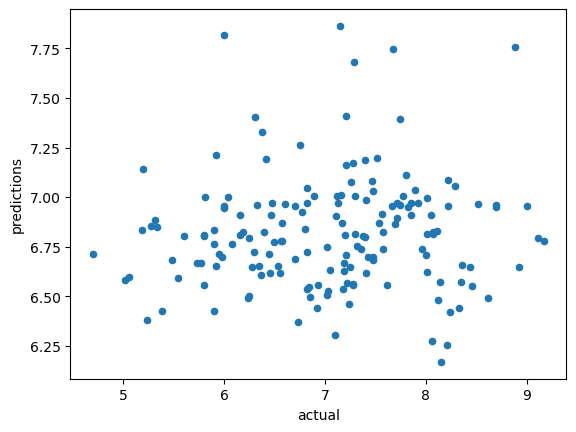

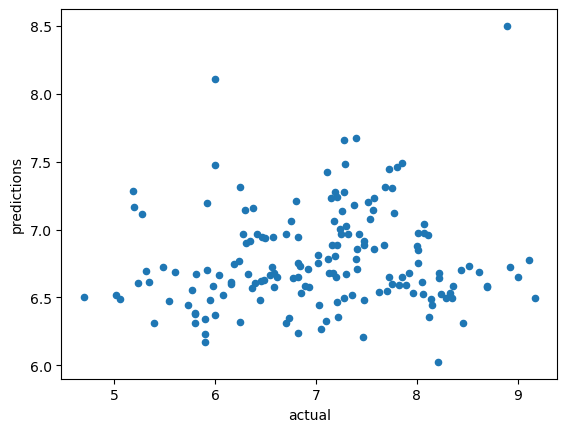

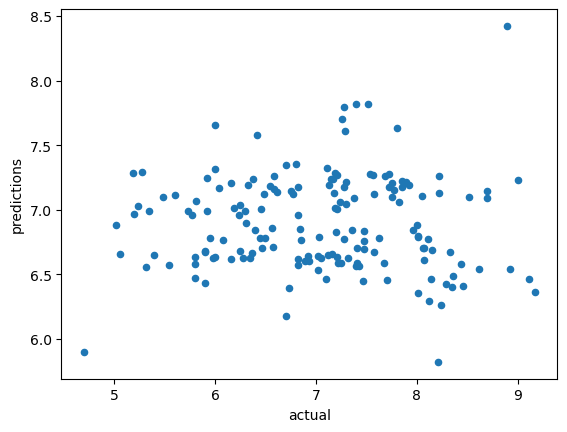

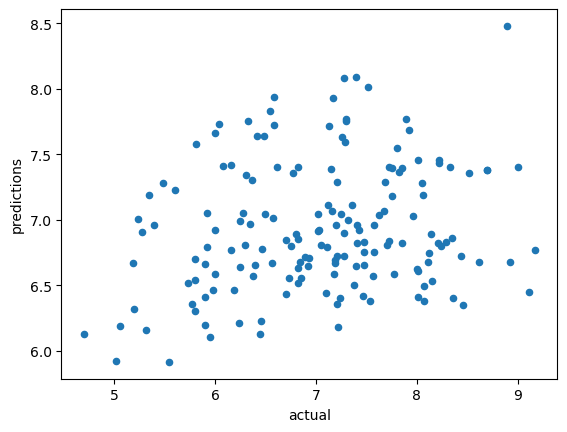

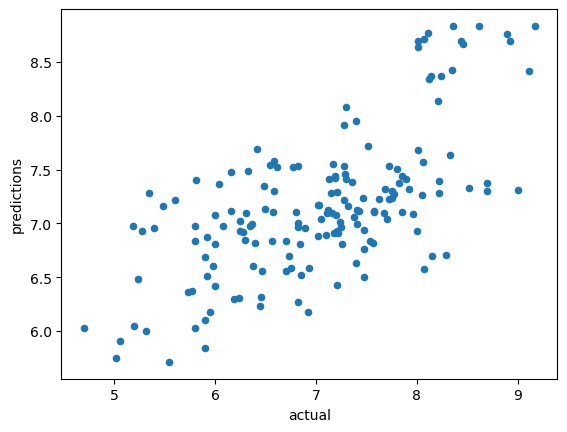

In [16]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X, y, smiles, sort_by=None, additional_info=df["QED"])

In [17]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [18]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)
(0, 3)


In [19]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(159, 3)
(159, 3)
(159, 3)
(159, 3)
(159, 3)
(159, 3)
(159, 3)
(159, 3)
(159, 3)


In [20]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(4, 3)
(4, 3)
(4, 3)
(4, 3)
(4, 3)
(4, 3)
(4, 3)
(4, 3)
(4, 3)


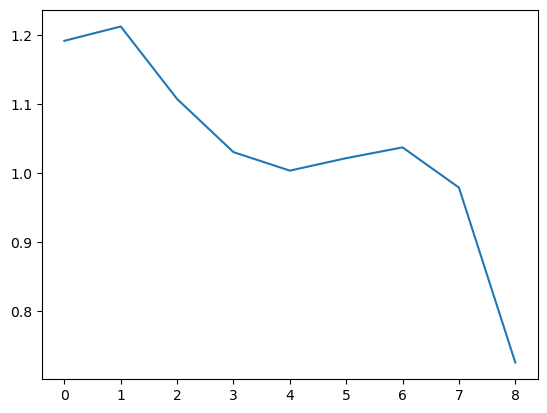

[1.1919858472306777, 1.2127949643428253, 1.1076064177558798, 1.0305289922142113, 1.0037195538367283, 1.0218008555603428, 1.0374168748363028, 0.979094113556618, 0.7254518778164676]


In [21]:
plt.plot(rmse)
plt.show()
print(rmse)